<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_15_resampling_LogReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Problem Description
We are working with an imbalanced loan default dataset, attempting to improve the performance of a logistic regression model by addressing class imbalance using resampling techniques. Despite applying both undersampling and oversampling methods, the performance metrics (Recall for Class 1, F1 Score (balanced), and F1 Score (macro)) remain the same as the baseline model, which does not use any resampling technique.

### Summary of Attempts

1. **Baseline Model**:
   - **Setup**: Loaded and preprocessed the data, defined a logistic regression model with class weights, and evaluated its performance without any resampling.
   - **Results**: The baseline model's performance metrics were recorded for comparison.

2. **Resampling Inside the Pipeline**:
   - **Method**: Integrated resampling (both undersampling and oversampling) directly into the machine learning pipeline using `imblearn.pipeline.Pipeline`.
   - **Execution**: The pipeline included preprocessing steps, the resampling step, and the logistic regression model.
   - **Observation**: The performance metrics of the model with resampling inside the pipeline were identical to the baseline model, suggesting that the resampling step might not have been applied correctly.

3. **Resampling Outside the Pipeline**:
   - **Method**: Applied the resampling step manually to the training data before fitting the machine learning pipeline.
   - **Execution**: The pipeline handled preprocessing and classification, but the resampling was performed on the training data beforehand.
   - **Observation**: Despite resampling outside the pipeline, the performance metrics remained the same as the baseline model, indicating that resampling did not have the expected impact on model performance.

### Analysis
The consistent results across different approaches suggest that resampling might not be effectively addressing the class imbalance in this particular dataset. Several factors could contribute to this outcome:

1. **Model Sensitivity**: The logistic regression model might not be sensitive enough to changes in class distribution introduced by resampling.
2. **Data Characteristics**: The inherent characteristics of the dataset (e.g., feature distribution, noise) might limit the effectiveness of resampling techniques.
3. **Implementation Issues**: Potential issues in how resampling is applied or integrated within the pipeline might lead to ineffective adjustments to the class distribution.

### Next Steps
Given the persistent issue, here are a few recommendations for further investigation and potential solutions:

1. **Experiment with Different Resampling Techniques**:
   - **SMOTE (Synthetic Minority Over-sampling Technique)**: Generates synthetic samples for the minority class.
   - **ADASYN (Adaptive Synthetic Sampling)**: Similar to SMOTE but focuses on more difficult-to-classify samples.
   - **Combination of Over and Under-sampling**: First oversample the minority class and then undersample the majority class.

2. **Explore Alternative Models**:
   - **Tree-based Models**: Random Forest or Gradient Boosting classifiers might handle class imbalance better due to their ability to capture complex patterns.
   - **Ensemble Methods**: Techniques like Bagging or Boosting can help improve model performance.

3. **Hyperparameter Tuning**:
   - Adjusting hyperparameters of the logistic regression model or alternative models might improve sensitivity to resampling.

4. **Feature Engineering**:
   - Creating new features or transforming existing ones might provide better separation between classes, enhancing model performance.

By exploring these options, we can better understand the limitations of our current approach and identify more effective strategies for addressing class imbalance in the dataset.

### No Resampling Baseline Model

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, recall_score, f1_score
from loan_data_utils import load_and_preprocess_data
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)

# Parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and preprocess data
X, y = load_and_preprocess_data(url, categorical_columns, target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])

# Define the logistic regression model with class weights
baseline_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)

# Create the baseline pipeline
baseline_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', baseline_model)
])

# Fit the baseline pipeline to the training data
baseline_pipeline.fit(X_train, y_train)

# Predict probabilities for the test data
optimal_threshold = 0.25
baseline_y_proba = baseline_pipeline.predict_proba(X_test)[:, 1]
baseline_y_pred = (baseline_y_proba >= optimal_threshold).astype(int)

# Evaluate the baseline model
baseline_recall_class1 = recall_score(y_test, baseline_y_pred, pos_label=1)
baseline_f1_balanced = f1_score(y_test, baseline_y_pred, average='binary', pos_label=1)
baseline_f1_macro = f1_score(y_test, baseline_y_pred, average='macro')

print("Baseline Model Performance with Optimal Threshold:")
print(f"Recall Class 1: {baseline_recall_class1:.4f}")
print(f"F1 Score (balanced): {baseline_f1_balanced:.4f}")
print(f"F1 Score (macro): {baseline_f1_macro:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, baseline_y_pred))

# Save the baseline results
baseline_results = {
    'Method': 'Baseline',
    'Recall Class 1': baseline_recall_class1,
    'F1 Score (balanced)': baseline_f1_balanced,
    'F1 Score (macro)': baseline_f1_macro,
    'Threshold': 'Optimal (0.25)'
}


Baseline Model Performance with Optimal Threshold:
Recall Class 1: 0.9254
F1 Score (balanced): 0.3795
F1 Score (macro): 0.3265

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.16      0.27      4673
           1       0.24      0.93      0.38      1327

    accuracy                           0.33      6000
   macro avg       0.56      0.54      0.33      6000
weighted avg       0.74      0.33      0.30      6000



### Resampling inside Pipeline



In [8]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler

# Define the resampling method
resampler_inside = RandomOverSampler(random_state=42)

# Create the resampled pipeline
resampled_pipeline_inside = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('resampler', resampler_inside),
    ('classifier', baseline_model)
])

# Fit the resampled pipeline to the training data
resampled_pipeline_inside.fit(X_train, y_train)

# Predict probabilities for the test data
resampled_y_proba_inside = resampled_pipeline_inside.predict_proba(X_test)[:, 1]
resampled_y_pred_inside = (resampled_y_proba_inside >= optimal_threshold).astype(int)

# Evaluate the model
resampled_recall_class1_inside = recall_score(y_test, resampled_y_pred_inside, pos_label=1)
resampled_f1_balanced_inside = f1_score(y_test, resampled_y_pred_inside, average='binary', pos_label=1)
resampled_f1_macro_inside = f1_score(y_test, resampled_y_pred_inside, average='macro')

print("Resampled Model Performance with Optimal Threshold (Inside Pipeline):")
print(f"Recall Class 1: {resampled_recall_class1_inside:.4f}")
print(f"F1 Score (balanced): {resampled_f1_balanced_inside:.4f}")
print(f"F1 Score (macro): {resampled_f1_macro_inside:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, resampled_y_pred_inside))

# Save the resampled results
resampled_results_inside = {
    'Method': 'Random Oversampling (Inside Pipeline)',
    'Recall Class 1': resampled_recall_class1_inside,
    'F1 Score (balanced)': resampled_f1_balanced_inside,
    'F1 Score (macro)': resampled_f1_macro_inside,
    'Threshold': 'Optimal (0.25)'
}


Resampled Model Performance with Optimal Threshold (Inside Pipeline):
Recall Class 1: 0.9239
F1 Score (balanced): 0.3789
F1 Score (macro): 0.3258

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.16      0.27      4673
           1       0.24      0.92      0.38      1327

    accuracy                           0.33      6000
   macro avg       0.56      0.54      0.33      6000
weighted avg       0.74      0.33      0.30      6000



### Resampling Outside Pipeline

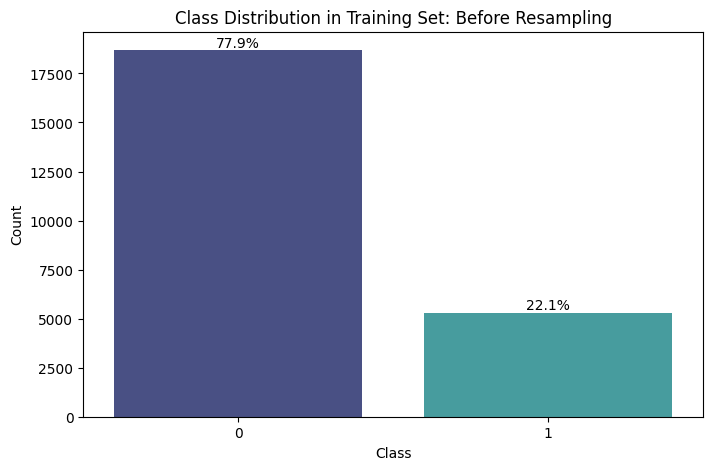

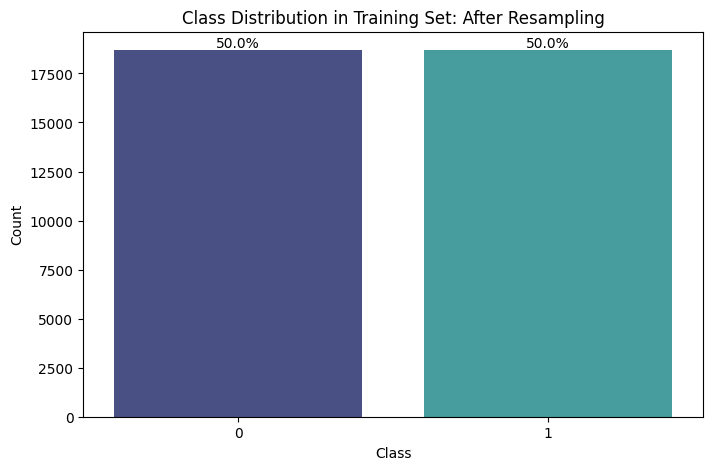

Resampled Model Performance with Optimal Threshold (Outside Pipeline):
Recall Class 1: 0.9239
F1 Score (balanced): 0.3789
F1 Score (macro): 0.3258

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.16      0.27      4673
           1       0.24      0.92      0.38      1327

    accuracy                           0.33      6000
   macro avg       0.56      0.54      0.33      6000
weighted avg       0.74      0.33      0.30      6000



In [9]:
# Define the resampling method
resampler_outside = RandomOverSampler(random_state=42)

# Resample the training data
X_resampled_outside, y_resampled_outside = resampler_outside.fit_resample(X_train, y_train)

# Plot class distribution before resampling
plot_class_distribution(y_train, 'Before Resampling')

# Plot class distribution after resampling
plot_class_distribution(y_resampled_outside, 'After Resampling')

# Create the pipeline
pipeline_outside = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', baseline_model)
])

# Fit the pipeline to the resampled training data
pipeline_outside.fit(X_resampled_outside, y_resampled_outside)

# Predict probabilities for the test data
resampled_y_proba_outside = pipeline_outside.predict_proba(X_test)[:, 1]
resampled_y_pred_outside = (resampled_y_proba_outside >= optimal_threshold).astype(int)

# Evaluate the model
resampled_recall_class1_outside = recall_score(y_test, resampled_y_pred_outside, pos_label=1)
resampled_f1_balanced_outside = f1_score(y_test, resampled_y_pred_outside, average='binary', pos_label=1)
resampled_f1_macro_outside = f1_score(y_test, resampled_y_pred_outside, average='macro')

print("Resampled Model Performance with Optimal Threshold (Outside Pipeline):")
print(f"Recall Class 1: {resampled_recall_class1_outside:.4f}")
print(f"F1 Score (balanced): {resampled_f1_balanced_outside:.4f}")
print(f"F1 Score (macro): {resampled_f1_macro_outside:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, resampled_y_pred_outside))

# Save the resampled results
resampled_results_outside = {
    'Method': 'Random Oversampling (Outside Pipeline)',
    'Recall Class 1': resampled_recall_class1_outside,
    'F1 Score (balanced)': resampled_f1_balanced_outside,
    'F1 Score (macro)': resampled_f1_macro_outside,
    'Threshold': 'Optimal (0.25)'
}


###Compare Results

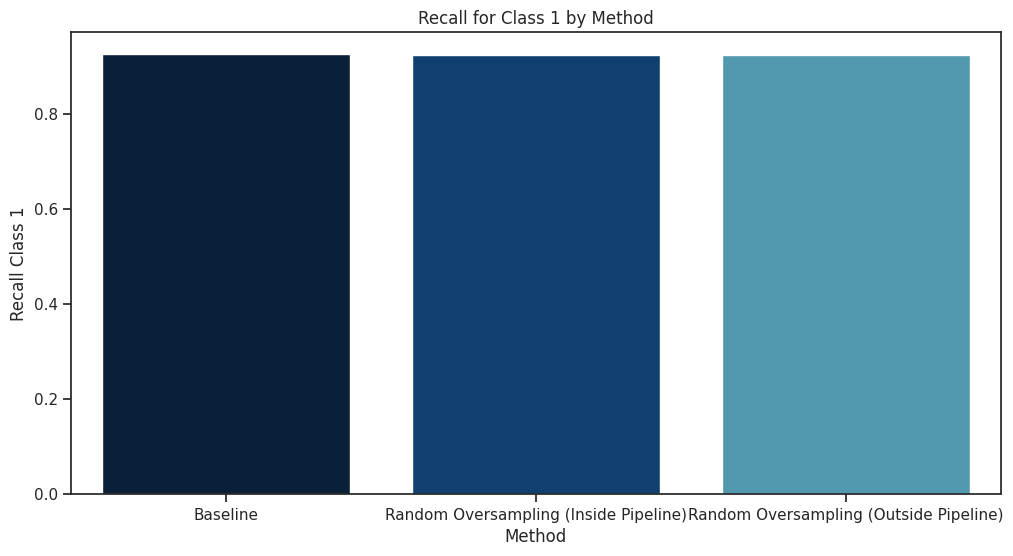

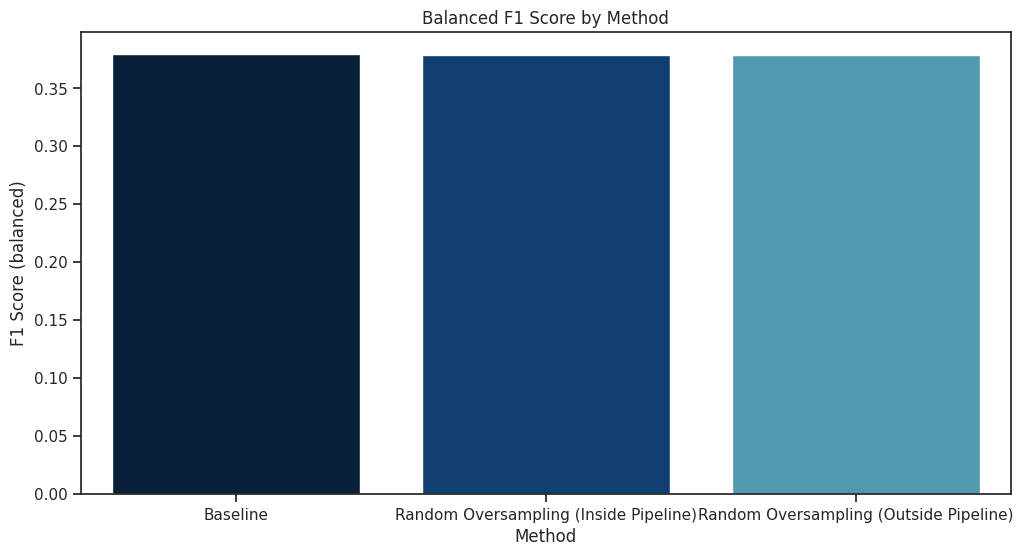

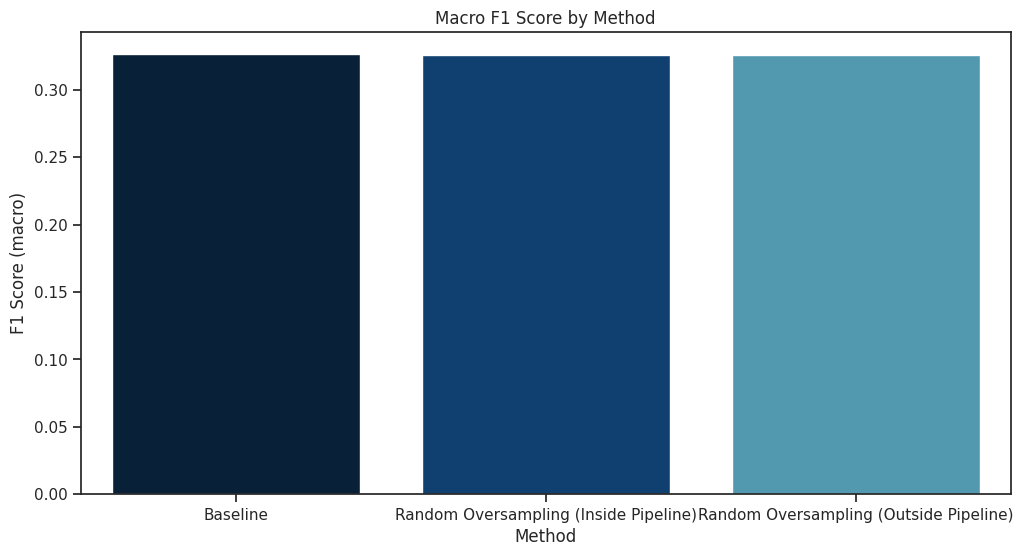

In [12]:
# Combine the results into a single DataFrame
results_df = pd.DataFrame([baseline_results, resampled_results_inside, resampled_results_outside])

# Function to plot the performance metrics for combined results
def plot_combined_metrics(results_df, metric, title, ylabel):
    sns.set_context('notebook')
    sns.set_style('ticks')
    fig, ax = plt.subplots(figsize=(12, 6))

    sns.barplot(x='Method', y=metric, hue='Method', data=results_df, palette='ocean', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Method')
    ax.set_ylabel(ylabel)

    plt.show()

# Metrics to plot
metrics = [
    ('Recall Class 1', 'Recall for Class 1 by Method', 'Recall Class 1'),
    ('F1 Score (balanced)', 'Balanced F1 Score by Method', 'F1 Score (balanced)'),
    ('F1 Score (macro)', 'Macro F1 Score by Method', 'F1 Score (macro)')
]

# Loop through the metrics and create plots
for metric, title, ylabel in metrics:
    plot_combined_metrics(results_df, metric, title, ylabel)

In [13]:
# Display the combined results
print("Combined Performance Metrics:")
results_df

Combined Performance Metrics:


,Method,Recall Class 1,F1 Score (balanced),F1 Score (macro),Threshold
0,Baseline,0.925396,0.379481,0.326499,Optimal (0.25)
1,Random Oversampling (Inside Pipeline),0.923888,0.378863,0.325828,Optimal (0.25)
2,Random Oversampling (Outside Pipeline),0.923888,0.378863,0.325828,Optimal (0.25)


Given that the results for both resampling inside and outside the pipeline are almost identical to the baseline model, it seems that the resampling is not having the intended effect on improving recall or other metrics. Here are some recommendations to address this:

1. **Verify Resampling**: Ensure that the resampling is applied correctly. Since the class distribution was confirmed to be 50/50 after resampling, this step is likely correct.

2. **Explore Different Resampling Methods**: Random oversampling might not be the most effective method for your dataset. Consider using other techniques like SMOTE (Synthetic Minority Over-sampling Technique) or ADASYN (Adaptive Synthetic Sampling).

3. **Adjust Model Parameters**: Tuning the hyperparameters of your logistic regression model could help. Using techniques like grid search or randomized search for hyperparameter tuning might improve performance.

4. **Feature Engineering**: Investigate creating new features or transforming existing ones. Sometimes, improving feature quality can significantly enhance model performance.

5. **Use Different Models**: Logistic regression might not be the best model for your data. Consider using more complex models like Random Forests, Gradient Boosting, or XGBoost, which might perform better.

### Summary

1. **Try Different Resampling Methods**: Use SMOTE or ADASYN instead of random oversampling.
2. **Hyperparameter Tuning**: Use grid search to find the best hyperparameters for the logistic regression model.
3. **Combine and Compare Results**: Evaluate and compare the performance of different approaches.

These steps should help in identifying a more effective strategy for improving model performance, especially for recall in class 1.

### Write Loan Data Utils Script

In [1]:
script_content=r'''
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def load_data_from_url(url):
    try:
        df = pd.read_excel(url, header=1)
        logging.info("Data loaded successfully from URL.")
    except Exception as e:
        logging.error(f"Error loading data from URL: {e}")
        return None
    return df

def clean_column_names(df):
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

def remove_id_column(df):
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    return df

def rename_columns(df):
    rename_dict = {'pay_0': 'pay_1'}
    df = df.rename(columns=rename_dict)
    return df

def convert_categorical(df, categorical_columns):
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

def split_features_target(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    return X, y

def load_and_preprocess_data(url, categorical_columns, target):
    df = load_data_from_url(url)
    if df is not None:
        df = clean_column_names(df)
        df = remove_id_column(df)
        df = rename_columns(df)
        df = convert_categorical(df, categorical_columns)
        X, y = split_features_target(df, target)
        return X, y
    return None, None

def plot_class_distribution(y_train, target_name):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_train, hue=y_train, palette='mako')
    plt.title(f'Class Distribution in Training Set: {target_name}')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.legend([], [], frameon=False)

    # Calculate the percentage for each class
    total = len(y_train)
    class_counts = y_train.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()


'''

# Write the script to a file
with open("loan_data_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to loan_data_utils.py")
# Reload script to make functions available for use
import importlib
import loan_data_utils
importlib.reload(loan_data_utils)

from loan_data_utils import *


Script successfully written to loan_data_utils.py
